In [3]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.datasets import Planetoid
import matplotlib.pyplot as plt

# Load dataset
dataset = Planetoid(root='/tmp/Cora', name='Cora')


In [12]:
print(dataset)

Cora()


In [5]:
class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(dataset.num_node_features, 16)
        self.conv2 = GCNConv(16, dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)



In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN().to(device)
data = dataset[0].to(device)



In [17]:
for i in dataset:
    print(i)

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


In [15]:
type(dataset)

torch_geometric.datasets.planetoid.Planetoid

Dataset: Cora()
Number of graphs: 1
Number of features: 1433
Number of classes: 7

Graph information:
Number of nodes: 2708
Number of edges: 10556
Number of training nodes: 140
Number of validation nodes: 500
Number of test nodes: 1000
Is undirected: True

Node features for the first 5 nodes:
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

Labels for the first 5 nodes:
tensor([3, 4, 4, 0, 3])


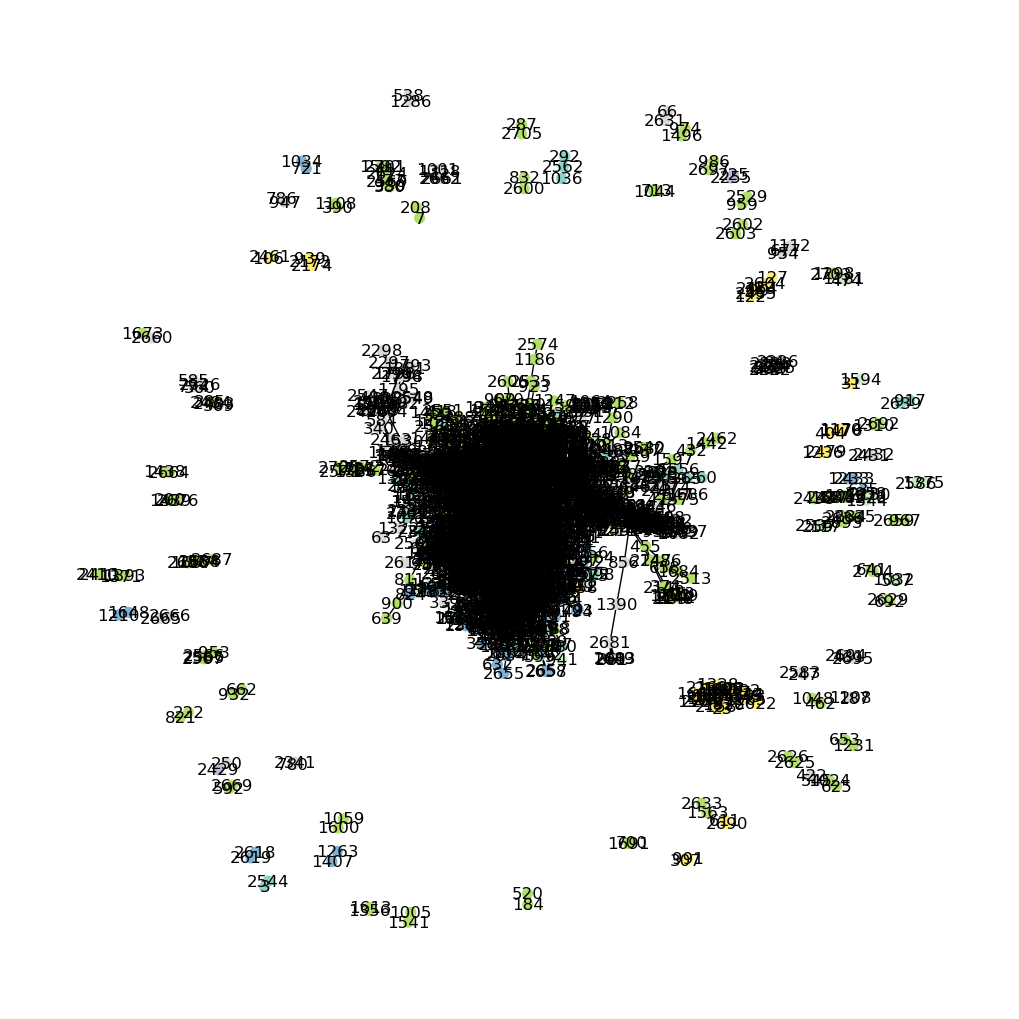

In [21]:
from torch_geometric.utils import to_networkx
import networkx as nx

# Print basic information about the dataset
print(f'Dataset: {dataset}')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_node_features}')
print(f'Number of classes: {dataset.num_classes}')

# Print information about the graph
print(f'\nGraph information:')
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Number of validation nodes: {data.val_mask.sum()}')
print(f'Number of test nodes: {data.test_mask.sum()}')
print(f'Is undirected: {data.is_undirected()}')

# Print node features and labels for the first 5 nodes
print('\nNode features for the first 5 nodes:')
print(data.x[:5])
print('\nLabels for the first 5 nodes:')
print(data.y[:5])

# Visualize the graph
G = to_networkx(data, to_undirected=True)
plt.figure(figsize=(10, 10))
nx.draw(G, with_labels=True, node_color=data.y, cmap=plt.get_cmap('Set3'), node_size=50)
plt.show()

In [7]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)



In [8]:

losses = []
accuracies = []

model.train()
for epoch in range(200):
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    
    losses.append(loss.item())
    
    model.eval()
    _, pred = model(data).max(dim=1)
    correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
    acc = int(correct) / int(data.test_mask.sum())
    accuracies.append(acc)
    model.train()

print('Final Accuracy: {:.4f}'.format(acc))



Final Accuracy: 0.7960


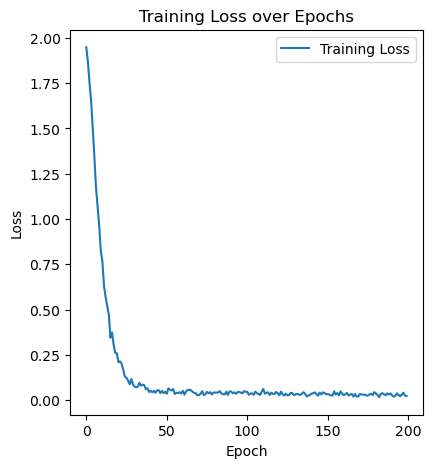

In [9]:
# Plotting loss over epochs
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()



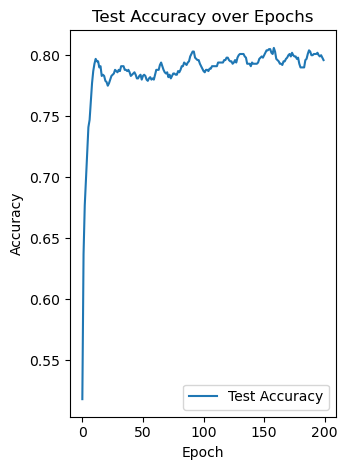

In [10]:
# Plotting accuracy over epochs
plt.subplot(1, 2, 2)
plt.plot(accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Test Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()